## JSON Mapping

In [1]:
import pandas as pd
import json

In [3]:
import pandas as pd
import json

excel_file = "EDI X12 Code reference.xlsx"

sheet_numbers = [2, 3, 4, 5, 6, 7, 8, 9]
names = ["EB01", "EB02", "EB03", "EB04", "EB06", "EB09", "EB11", "EB12"]

final_json = {}

for sheet_index, eb_name in zip(sheet_numbers, names):
    sheet_index -= 1

    # Read that sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_index)

    # Identify column names dynamically
    code_col = None
    def_col = None

    # Find the correct columns ("EB__ Codes" and "definition")
    for col in df.columns:
        if "Codes" in col:      # e.g., "EB01 Codes", "EB02 Codes"
            code_col = col
        if "definition" in col.lower():
            def_col = col

    if code_col is None or def_col is None:
        print(f"⚠️ Skipping sheet {sheet_index} ({eb_name}) - Columns not found.")
        continue

    # Drop rows missing either code or definition
    df = df.dropna(subset=[code_col, def_col])

    # Build mapping dictionary
    eb_dict = {
        str(row[code_col]).strip(): str(row[def_col]).strip()
        for _, row in df.iterrows()
    }

    # Attach to final JSON
    final_json[eb_name] = eb_dict

# Save final mapping JSON
output_file = "EB_mapping.json"
with open(output_file, "w") as f:
    json.dump(final_json, f, indent=4)

print("Saved:", output_file)

⚠️ Skipping sheet 1 (EB01) - Columns not found.
Saved: EB_mapping.json
Saved: EB_mapping.json


## EDA

In [5]:
import os
import json
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [6]:
def extract_EB_keys(d):
    """Return only keys that start with '@EB' sorted."""
    eb_keys = sorted([k for k in d.keys() if k.startswith("@EB")])
    return tuple(eb_keys)

In [9]:
with open("EB_mapping.json", "r") as f:
    eb_mapping = json.load(f)

folder_path = "data"
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
len(json_files)

400

In [10]:
count_hl3 = 0;
count_hl4 = 0

combo_counter = Counter()
eb02_counter = Counter()
eb_value_counter = defaultdict(Counter)

total_words = 0      
total_eb_words = 0 
total_eb_words_sub = 0
only_eb_words = 0
only_eb_words_sub = 0
file_count = 0
min_eb_words = 999999
max_eb_words = 0
min_eb_words_sub = 999999
max_eb_words_sub = 0

msg_total = 0
msg_files = 0

dtp_total = 0
dtp_files = 0


for filename in tqdm(json_files, desc="Processing JSON files"):
    file_path = os.path.join(folder_path, filename)

    with open(file_path, "r") as f:
        data = json.load(f)

    # -----------------------------
    # WORD COUNT FOR THE ENTIRE FILE
    # -----------------------------
    text_repr = json.dumps(data)
    file_word_count = len(text_repr.split())
    total_words += file_word_count
    file_count += 1

    # -----------------------------
    # HL3 / HL4 CHECK
    # -----------------------------
    try:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
        count_hl4 += 1
    except:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]
        count_hl3 += 1

    # Ensure EB is a list
    if isinstance(eb_data, dict):
        eb_data = [eb_data]

    # -----------------------------
    # WORD COUNT INSIDE EB BLOCK
    # -----------------------------
    eb_text = json.dumps(eb_data)
    eb_words = len(eb_text.split())
    total_eb_words += eb_words
    max_eb_words = max(max_eb_words, eb_words)
    min_eb_words = min(min_eb_words, eb_words)

    eb_word_count_before = 0;
    for eb_entry in eb_data:
        for key, value in eb_entry.items():
            if key.startswith("@EB") and len(key) == 5:
                # Count words in EBxx value
                eb_word_count_before += len(str(value).split())

    only_eb_words += eb_word_count_before

    # -----------------------------
    # PROCESS EACH EB ENTRY
    # -----------------------------
    for eb_entry in eb_data:

        # --- COMBO KEYS ---
        combo = extract_EB_keys(eb_entry)
        if combo:
            combo_counter[combo] += 1

        # --- EB02 COUNT ---
        eb02_value = eb_entry.get("@EB02")
        if eb02_value:
            eb02_counter[eb02_value] += 1


        if "MSG" in eb_entry:
            msg_block = eb_entry["MSG"]

            # Count all key-value pairs inside MSG
            # e.g., {'@MSG01': 'ABC', '@MSG02': 'DEF'} → 2 keys
            msg_total += len(msg_block)

            msg_files += 1  # count file-level occurrence

        if "DTP" in eb_entry:
            dtp_block = eb_entry["DTP"]

            # Count all key-value pairs inside DTP
            # e.g., {'@DTP01': 'ABC', '@DTP02': 'DEF'} → 2 keys
            dtp_total += len(dtp_block)

            dtp_files += 1  # count file-level occurrence

    # --------------------------------------------------------------------
    # SUBSTITUTE EBxx CODES USING eb_mapping (WITH ^ MULTI-CODE SUPPORT)
    # --------------------------------------------------------------------
    for eb_entry in eb_data:

        for key, value in list(eb_entry.items()):

            # Only fields like @EB01, @EB02, @EB03...
            if key.startswith("@EB") and len(key) == 5:

                eb_key = key[1:]                   # "@EB03" → "EB03"
                raw_value = str(value).strip()     # e.g., "UC", "UC^86"

                mapped_value = None  # default
                
                # ---------------------------------------------------------
                # CASE 1: Multi-code value (example: "UC^86")
                # ---------------------------------------------------------
                if "^" in raw_value:
                    split_codes = raw_value.split("^")

                    mapped_list = []
                    for code in split_codes:
                        code = code.strip()
                        if eb_key in eb_mapping and code in eb_mapping[eb_key]:
                            mapped_list.append(eb_mapping[eb_key][code])
                        else:
                            mapped_list.append(code)  # fallback if no mapping

                    # Join mapped items with comma
                    mapped_value = ", ".join(mapped_list)

                # ---------------------------------------------------------
                # CASE 2: Single code value (example: "UC")
                # ---------------------------------------------------------
                else:
                    if eb_key in eb_mapping and raw_value in eb_mapping[eb_key]:
                        mapped_value = eb_mapping[eb_key][raw_value]
                    else:
                        mapped_value = raw_value  # fallback

                # ---------------------------------------------------------
                # REPLACE ORIGINAL VALUE
                # ---------------------------------------------------------
                eb_entry[key] = mapped_value

                # Track frequency for summary (mapped_value may be multi)
                eb_value_counter[eb_key][mapped_value] += 1


    # -----------------------------
    # WORD COUNT INSIDE EB BLOCK (AFTER SUBSTITUION)
    # -----------------------------
    eb_text = json.dumps(eb_data)
    eb_words = len(eb_text.split())
    total_eb_words_sub += eb_words
    max_eb_words_sub = max(max_eb_words_sub, eb_words)
    min_eb_words_sub = min(min_eb_words_sub, eb_words)

    eb_word_count_after = 0
    for eb_entry in eb_data:
        for key, value in eb_entry.items():
            if key.startswith("@EB") and len(key) == 5:
                eb_word_count_after += len(str(value).split())

    only_eb_words_sub += eb_word_count_after

Processing JSON files: 100%|██████████| 400/400 [00:00<00:00, 879.77it/s]


In [11]:
import copy
count_hl3 = 0
count_hl4 = 0

combo_counter = Counter()
eb02_counter = Counter()
eb_value_counter = defaultdict(Counter)

total_words = 0
total_eb_words = 0
total_eb_words_sub = 0
only_eb_words = 0
only_eb_words_sub = 0
file_count = 0

min_eb_words = 999999
max_eb_words = 0
min_eb_words_sub = 999999
max_eb_words_sub = 0

msg_total = 0
msg_files = 0
dtp_total = 0
dtp_files = 0

# Track maximum EB block
file_with_max_eb_sub = None
eb_block_max_after_sub = None


for filename in tqdm(json_files, desc="Processing JSON files"):
    file_path = os.path.join(folder_path, filename)

    with open(file_path, "r") as f:
        data = json.load(f)

    # -----------------------------
    # WORD COUNT FOR THE ENTIRE FILE
    # -----------------------------
    text_repr = json.dumps(data)
    file_word_count = len(text_repr.split())
    total_words += file_word_count
    file_count += 1

    # -----------------------------
    # HL3 / HL4 CHECK
    # -----------------------------
    try:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
        count_hl4 += 1
    except:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]
        count_hl3 += 1

    # Ensure EB is list
    if isinstance(eb_data, dict):
        eb_data = [eb_data]

    # -----------------------------
    # EB WORD COUNT BEFORE
    # -----------------------------
    eb_text = json.dumps(eb_data)
    eb_words = len(eb_text.split())
    total_eb_words += eb_words
    max_eb_words = max(max_eb_words, eb_words)
    min_eb_words = min(min_eb_words, eb_words)

    eb_word_count_before = sum(
        len(str(v).split())
        for entry in eb_data
        for k, v in entry.items()
        if k.startswith("@EB") and len(k) == 5
    )
    only_eb_words += eb_word_count_before

    # -----------------------------
    # PROCESS EB ENTRY
    # -----------------------------
    for eb_entry in eb_data:

        combo = extract_EB_keys(eb_entry)
        if combo:
            combo_counter[combo] += 1

        eb02_value = eb_entry.get("@EB02")
        if eb02_value:
            eb02_counter[eb02_value] += 1

        if "MSG" in eb_entry:
            msg_total += len(eb_entry["MSG"])
            msg_files += 1

        if "DTP" in eb_entry:
            dtp_total += len(eb_entry["DTP"])
            dtp_files += 1

    # -----------------------------------------------------
    # SUBSTITUTE EBxx CODES — SAFE VERSION
    # -----------------------------------------------------
    for eb_entry in eb_data:
        for key, value in list(eb_entry.items()):

            if not (key.startswith("@EB") and len(key) == 5):
                continue

            eb_key = key[1:]            # "@EB03" → "EB03"
            raw_value = str(value).strip()

            # --- If EB key NOT in mapping → skip safely ---
            if eb_key not in eb_mapping:
                continue

            # MULTI-VALUE CASE
            if "^" in raw_value:
                split_codes = raw_value.split("^")
                mapped_value = ", ".join(
                    eb_mapping[eb_key].get(code.strip(), code.strip())
                    for code in split_codes
                )
            else:
                # SINGLE-VALUE CASE (safe)
                mapped_value = eb_mapping[eb_key].get(raw_value, raw_value)

            # replace
            eb_entry[key] = mapped_value

            # track
            eb_value_counter[eb_key][mapped_value] += 1

    # -----------------------------
    # EB WORD COUNT AFTER
    # -----------------------------
    eb_text = json.dumps(eb_data)
    eb_words = len(eb_text.split())
    total_eb_words_sub += eb_words

    # Track file with max EB words after substitution
    if eb_words > max_eb_words_sub:
        max_eb_words_sub = eb_words
        file_with_max_eb_sub = filename
        eb_block_max_after_sub = copy.deepcopy(eb_data)

    min_eb_words_sub = min(min_eb_words_sub, eb_words)

    eb_word_count_after = sum(
        len(str(v).split())
        for entry in eb_data
        for k, v in entry.items()
        if k.startswith("@EB") and len(k) == 5
    )
    only_eb_words_sub += eb_word_count_after


Processing JSON files: 100%|██████████| 400/400 [00:00<00:00, 1119.39it/s]


In [12]:
print("\n======================================")
print("FILE WITH MAXIMUM EB WORD COUNT AFTER SUBSTITUTION")
print("======================================")
print("Filename:", file_with_max_eb_sub)
print("EB Word Count:", max_eb_words_sub)

print("\nEB BLOCK (after substitution):")
print(json.dumps(eb_block_max_after_sub, indent=4))



FILE WITH MAXIMUM EB WORD COUNT AFTER SUBSTITUTION
Filename: CIGNA-Garibaldi-271.json
EB Word Count: 8994

EB BLOCK (after substitution):
[
    {
        "@EB01": "1",
        "@EB03": "30",
        "@EB05": "OPEN ACCESS PLUS",
        "MSG": [
            {
                "@MSG01": "SERVICES PROVIDED BY JB HUNT BARIATRIC CSN ARE COVERED UNDER IN-NETWORK BENEFITS UNLESS OTHERWISE SPECIFIED."
            },
            {
                "@MSG01": "NEW BUSINESS RATES APPLIED"
            },
            {
                "@MSG01": "COMPLETE CARE MANAGEMENT"
            }
        ]
    },
    {
        "@EB01": "C",
        "@EB02": "FAM",
        "@EB03": "30",
        "@EB06": "Calendar Year",
        "@EB07": "4000",
        "@EB12": "Services Restricted to Following Provider",
        "MSG": {
            "@MSG01": "BENEFIT DOES APPLY TO MEMBER'S OUT-OF-POCKET MAXIMUM"
        }
    },
    {
        "@EB01": "A",
        "@EB02": "FAM",
        "@EB03": "30",
        "@EB08": ".5",
 

In [13]:

def count_eb_value_words(json_file_path):
    # Load JSON
    with open(json_file_path, "r") as f:
        data = json.load(f)

    # Detect HL3 vs HL4 automatically
    try:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]   # HL4
    except KeyError:
        eb_data = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]         # HL3

    # Ensure EB block is a list
    if isinstance(eb_data, dict):
        eb_data = [eb_data]

    # Count only EB value words
    eb_value_word_count = 0

    for eb_entry in eb_data:
        for key, value in eb_entry.items():
            # Only fields like @EB01, @EB02, @EB03...
            if key.startswith("@EB") and len(key) == 5:
                eb_value_word_count += len(str(value).split())

    return eb_value_word_count


# ==================================
# USE THE FUNCTION
# ==================================

json_file = "data/CIGNA-Garibaldi-271.json"   # <<<--- replace this

count = count_eb_value_words(json_file)
print(f"\nEB value word count for file '{os.path.basename(json_file)}': {count}\n")



EB value word count for file 'CIGNA-Garibaldi-271.json': 1721



In [7]:
print("\n===================== SUMMARY =====================")

print(f"Total files processed: {file_count}")
print(f"HL3 count: {count_hl3}")
print(f"HL4 count: {count_hl4}")
dep_percentage = (count_hl4 / (count_hl4+count_hl3) ) * 100
print(f"Dependent percentage: {dep_percentage}%")

print("\nWORD COUNTS")
average_words = total_words / file_count if file_count > 0 else 0
average_eb_words = total_eb_words / file_count if file_count > 0 else 0
average_eb_words_sub = total_eb_words_sub / file_count if file_count > 0 else 0
average_only_eb_words = only_eb_words / file_count if file_count > 0 else 0
average_only_eb_words_sub = only_eb_words_sub / file_count if file_count > 0 else 0

print(f"- Minimum words in EB block (before substitution): {min_eb_words}")
print(f"- Maximum words in EB block (before substitution): {max_eb_words}")
print(f"- Average words in EB block (before substitution): {average_eb_words:.2f}")
print(f"- Minimum words in EB block (after substitution): {min_eb_words_sub}")
print(f"- Maximum words in EB block (after substitution): {max_eb_words_sub}")
print(f"- Average words in EB block (after substitution): {average_eb_words_sub:.2f}")
print(f"- Average words in EB values only (before substitution): {average_only_eb_words:.2f}")
print(f"- Average words in EB values only (after substitution): {average_only_eb_words_sub:.2f}")

print("\nMSG SUMMARY")
print(f"- Total MSG keys found: {msg_total}")
if file_count > 0:
    print(f"- Average MSG per file: {msg_total / file_count:.2f}")
else:
    print("No files processed!")

print("\nDTP SUMMARY")
print(f"- Total DTP keys found: {dtp_total}")
if file_count > 0:
    print(f"- Average DTP per file: {dtp_total / file_count:.2f}")
else:
    print("No files processed!")

print("\nEB02 BREAKDOWN (sorted):")
total_eb02 = sum(eb02_counter.values())
for k, v in sorted(eb02_counter.items(), key=lambda x: x[1], reverse=True):
    pct = (v / total_eb02) * 100 if total_eb02 else 0
    print(f"  {k}: {v} ({pct:.2f}%)")



===================== SUMMARY =====================
Total files processed: 400
HL3 count: 364
HL4 count: 36
Dependent percentage: 9.0%

WORD COUNTS
- Minimum words in EB block (before substitution): 4
- Maximum words in EB block (before substitution): 7619
- Average words in EB block (before substitution): 1103.77
- Minimum words in EB block (after substitution): 7
- Maximum words in EB block (after substitution): 8309
- Average words in EB block (after substitution): 1335.34
- Average words in EB values only (before substitution): 255.92
- Average words in EB values only (after substitution): 487.49

MSG SUMMARY
- Total MSG keys found: 16622
- Average MSG per file: 41.55

DTP SUMMARY
- Total DTP keys found: 19255
- Average DTP per file: 48.14

EB02 BREAKDOWN (sorted):
  IND: 9276 (85.97%)
  FAM: 1206 (11.18%)
  ECH: 149 (1.38%)
  EMP: 100 (0.93%)
  ESP: 59 (0.55%)


In [14]:
eb_data

[{'@EB01': '1', '@EB03': '30', '@EB05': 'GOLD 12'},
 {'@EB01': '1',
  '@EB03': '1, 12, 13, 18, 2, 33, 4, 40, 45, 47, 5, 50, 51, 52, 53, 6, 62, 65, 68, 7, 73, 76, 78, 8, 80, 81, 82, 86, 99, A0, A6, A8, AF, AI, MH, UC',
  '@EB11': 'N'},
 {'@EB01': '1',
  '@EB03': '42',
  '@EB11': 'N',
  'MSG': {'@MSG01': 'NO PA REQUIRED FOR VISITS'}},
 {'@EB01': '1',
  '@EB03': '93, 98, A3, BH',
  '@EB11': 'N',
  'MSG': {'@MSG01': 'OFFICE VISIT - PRIMARY CARE'}},
 {'@EB01': '1',
  '@EB03': '20, 93, 98, A3, BH',
  '@EB11': 'N',
  'MSG': {'@MSG01': 'OFFICE VISIT - SPECIALTY CARE'}},
 {'@EB01': '1',
  '@EB03': '88',
  '@EB11': 'N',
  'MSG': {'@MSG01': 'PLEASE CONTACT CAREMARK AT (855) 322-4080 FOR BENEFIT INFO'}},
 {'@EB01': '1',
  '@EB03': 'AL',
  '@EB11': 'N',
  'MSG': {'@MSG01': 'PLEASE CONTACT VSP @ (800) 877-7195 FOR BENEFIT INFORMATION.'}},
 {'@EB01': '1',
  '@EB03': '33, 47, 48, A7, AD, AF, AG',
  '@EB11': 'None (Also Used to Cancel or Override a Previous Pattern)'},
 {'@EB01': '1',
  '@EB03': '42',


In [15]:
# Prepare rows for DataFrame
rows = []
for combo, freq in sorted(combo_counter.items(), key=lambda x: x[1], reverse=True):
    rows.append({
        "EB_Combination": " ".join(combo),
        "Frequency": freq,
        "Key_Count": len(combo)
    })

# Create DataFrame
df_excel = pd.DataFrame(rows)

# Save to Excel
output_xlsx = "eb_combinations.xlsx"
df_excel.to_excel(output_xlsx, index=False)

print(f"Saved Excel as {output_xlsx}")

Saved Excel as eb_combinations.xlsx


In [16]:
all_eb_keys = sorted(eb_value_counter.keys())  # e.g., ['EB01','EB02',...]

# Build ragged lists and then pad them
cols = {}
max_len = 0

for eb_key in all_eb_keys:
    counter = eb_value_counter[eb_key]
    values = list(counter.keys())
    freqs  = list(counter.values())

    cols[f"{eb_key}"] = values
    cols[f"{eb_key} Frequency"] = freqs
    max_len = max(max_len, len(values), len(freqs))

# pad each list to max_len
for k, lst in cols.items():
    if len(lst) < max_len:
        # pad with None (or "" if you prefer empty string)
        lst.extend([None] * (max_len - len(lst)))
    cols[k] = lst

# Now create DataFrame safely
df_wide = pd.DataFrame(cols)
df_wide

,EB02,EB02 Frequency,EB03,EB03 Frequency,EB04,EB04 Frequency,EB06,EB06 Frequency,EB09,EB09 Frequency,EB11,EB11 Frequency,EB12,EB12 Frequency
0,IND,9276.0,30,2687,MC,833.0,Contract,171.0,VS,600.0,U,894.0,Spend Down,7278.0
1,FAM,1206.0,96,115,MA,561.0,Remaining,1419.0,DY,648.0,N,2014.0,Other Source of Data,1786.0
2,ESP,59.0,50,801,MB,3733.0,Episode,340.0,CA,73.0,None (Also Used to Cancel or Override a Previo...,1296.0,Services Restricted to Following Provider,2354.0
3,EMP,100.0,44,54,HN,383.0,Day,814.0,99,145.0,None,NaN,Contact Following Entity for Eligibility or Be...,67.0
4,ECH,149.0,48,451,MP,44.0,Lifetime,109.0,DB,40.0,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,None,NaN,"33, 47, 48, A7, AD, AF, AG",1,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN
604,None,NaN,"1, 12, 13, 18, 2, 33, 4, 40, 45, 47, 48, 5, 50...",1,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN
605,None,NaN,"1, 12, 13, 18, 2, 33, 4, 40, 45, 47, 48, 5, 50...",1,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN
606,None,NaN,"1, 12, 13, 18, 2, 33, 4, 40, 47, 48, 5, 50, 51...",4,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN


In [11]:
out_xlsx = "eb_values_count.xlsx"
with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    df_wide.to_excel(writer, index=False, sheet_name="EB_values_wide")

print("Saved wide table to", out_xlsx)

Saved wide table to eb_values_count.xlsx


## MSG EDA

In [2]:
import os
import json
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [9]:
folder_path = "data"

# bucket size (50 words per bucket)
BUCKET_SIZE = 50

def get_bucket(word_count):
    """Return bucket like 50-100, 100-150, etc."""
    lower = (word_count // BUCKET_SIZE) * BUCKET_SIZE
    upper = lower + BUCKET_SIZE
    return f"{lower}-{upper}"

In [5]:

files_without_msg = []
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

for filename in tqdm(json_files, desc="Checking Files"):
    path = os.path.join(folder_path, filename)

    with open(path, "r") as f:
        data = json.load(f)

    # Handle two possible EB locations
    try:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
    except:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]

    found_msg = False

    for eb in eb_list:

        # EB must be a dict
        if not isinstance(eb, dict):
            continue

        if "MSG" in eb:
            found_msg = True
            break

    # If NO MSG found in this file, add to list
    if not found_msg:
        files_without_msg.append(filename)

print("\nFiles without any MSG fields:\n")
for f in files_without_msg:
    print(f)

print(f"\nTotal files without MSG: {len(files_without_msg)}")

Checking Files: 100%|██████████| 400/400 [00:00<00:00, 7529.43it/s]


Files without any MSG fields:

AETNA-Chimaera-271.json
MCAID_FL-Parore-271.json
MOLINA_TX-Remora-271.json
CIGNA-Livebearer-271.json
MCAID_FL-Bitterling-271.json
EXCELLUS_BCBS-Rivuline-271.json
MOLINA_TX-Codling-271.json
AETNA-Ghoul-271.json
UNITED_HEALTHCARE-Zingel-271.json
MCAID_TX-Sailfish-271.json
MCAID_AL-Kingfish-271.json
MCAID_FL-Oldwife-271.json
MCAID_FL-Vimba-271.json
MOLINA_TX-Dragonfish-271.json
MOLINA_TX-Nase-271.json
AETNA-Cobia-271.json
BCBS_FL-Croaker-271.json
MCAID_FL-Batfish-271.json
CIGNA-Eelpout-271.json
MOLINA_TX-Hammerjaw-271.json
UNITED_HEALTHCARE-Peamouth-271.json
MCAID_FL-Houndshark-271.json
BCBS_FL-Muskellunge-271.json
MCAID_FL-Stromateidae-271.json
MCAID_FL-Trumpetfish-271.json
MCAID_FL-Bowfin-271.json
MCAID_FL-Pearleye-271.json
MCAID_FL-Tigerfish-271.json
CIGNA-Swordtail-271.json
MCAID_FL-Archerfish-271.json
EXCELLUS_BCBS-Char-271.json
MCAID_AL-Pumpkinseed-271.json
AETNA-Gunnel-271.json
MOLINA_TX-Ray-271.json
UNITED_HEALTHCARE-Vanjaram-271.json
MCAID_FL-Orfe-

In [ ]:
files_with_empty_msg = []    # <-- this is what we will print
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

for filename in tqdm(json_files, desc="Checking MSG Content"):
    path = os.path.join(folder_path, filename)

    with open(path, "r") as f:
        data = json.load(f)

    # EB extraction
    try:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
    except:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]

    found_msg = False
    total_msg_words = 0

    for eb in eb_list:
        if not isinstance(eb, dict):
            continue

        if "MSG" not in eb:
            continue

        found_msg = True    # MSG field exists

        msg_field = eb["MSG"]

        # ---------------------------------
        # CASE 1: MSG is a list (most common)
        # ---------------------------------
        if isinstance(msg_field, list):
            for msg_obj in msg_field:

                # If list element is a dict with "@MSG01"
                if isinstance(msg_obj, dict) and "@MSG01" in msg_obj:
                    val = msg_obj["@MSG01"]
                    if isinstance(val, str) and val.strip():
                        total_msg_words += len(val.strip().split())
                
                # If list element itself is a string
                elif isinstance(msg_obj, str) and msg_obj.strip():
                    total_msg_words += len(msg_obj.strip().split())

        # ---------------------------------
        # CASE 2: MSG is a dict (your example)
        # ---------------------------------
        elif isinstance(msg_field, dict):

            # If dict has @MSG01 key
            if "@MSG01" in msg_field:
                val = msg_field["@MSG01"]

                if isinstance(val, str) and val.strip():
                    total_msg_words += len(val.strip().split())

                elif isinstance(val, list):
                    for item in val:
                        if isinstance(item, str) and item.strip():
                            total_msg_words += len(item.strip().split())

        # ---------------------------------
        # CASE 3: MSG is a raw string
        # ---------------------------------
        elif isinstance(msg_field, str) and msg_field.strip():
            total_msg_words += len(msg_field.strip().split())

    # MSG exists but contains NO text
    if found_msg and total_msg_words == 0:
        files_with_empty_msg.append(filename)

print("\nFiles that contain MSG field BUT have no text:\n")
for f in files_with_empty_msg:
    print(f)

print(f"\nTotal such files: {len(files_with_empty_msg)}")

Checking MSG Content: 100%|██████████| 400/400 [00:00<00:00, 4869.14it/s]


Files that contain MSG field BUT have no text:


Total such files: 0


In [12]:
histogram = defaultdict(int)
all_word_counts = []   # for plotting
files_with_msg = 0     # correct MSG file counter

json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

for filename in tqdm(json_files, desc="Processing JSON"):
    path = os.path.join(folder_path, filename)

    with open(path, "r") as f:
        data = json.load(f)

    # EB extraction
    try:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
    except:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]

    total_msg_words = 0
    found_msg = False

    for eb in eb_list:
        if not isinstance(eb, dict):
            continue

        if "MSG" not in eb:
            continue

        found_msg = True   # file HAS MSG field (even empty)

        msg_field = eb["MSG"]

        # ------------------------------------------------------
        # CASE 1: MSG is a list of dicts
        # ------------------------------------------------------
        if isinstance(msg_field, list):
            for msg_obj in msg_field:
                if isinstance(msg_obj, dict) and "@MSG01" in msg_obj:
                    text = msg_obj["@MSG01"]
                    if isinstance(text, str) and text.strip():
                        total_msg_words += len(text.strip().split())

                elif isinstance(msg_obj, str) and msg_obj.strip():
                    total_msg_words += len(msg_obj.strip().split())

        # ------------------------------------------------------
        # ⭐ CASE 2: MSG is a dict (your missing case)
        # ------------------------------------------------------
        elif isinstance(msg_field, dict):
            if "@MSG01" in msg_field:
                text = msg_field["@MSG01"]

                if isinstance(text, str) and text.strip():
                    total_msg_words += len(text.strip().split())

                elif isinstance(text, list):
                    for item in text:
                        if isinstance(item, str) and item.strip():
                            total_msg_words += len(item.strip().split())

        # ------------------------------------------------------
        # CASE 3: MSG is a raw string
        # ------------------------------------------------------
        elif isinstance(msg_field, str) and msg_field.strip():
            total_msg_words += len(msg_field.strip().split())


    # Count files that contain MSG (regardless of text)
    if found_msg:
        files_with_msg += 1

    # Only include in histogram if MSG has text
    if total_msg_words > 0:
        all_word_counts.append(total_msg_words)
        bucket = get_bucket(total_msg_words)
        histogram[bucket] += 1

Processing JSON: 100%|██████████| 400/400 [00:00<00:00, 7087.16it/s]


In [13]:
print("\nHistogram of MSG Word Count Per File:\n")
for bucket in sorted(histogram.keys(), key=lambda x: int(x.split("-")[0])):
    print(f"{bucket} words : {histogram[bucket]} files")


Histogram of MSG Word Count Per File:

0-50 words : 166 files
50-100 words : 39 files
100-150 words : 23 files
150-200 words : 18 files
200-250 words : 10 files
250-300 words : 4 files
300-350 words : 7 files
350-400 words : 5 files
400-450 words : 5 files
450-500 words : 5 files
500-550 words : 9 files
550-600 words : 14 files
600-650 words : 6 files
650-700 words : 3 files
700-750 words : 6 files
750-800 words : 3 files
850-900 words : 6 files
900-950 words : 1 files
950-1000 words : 1 files
1000-1050 words : 1 files
1050-1100 words : 4 files
1200-1250 words : 2 files
1250-1300 words : 3 files
1550-1600 words : 1 files
1600-1650 words : 1 files
1650-1700 words : 1 files
1750-1800 words : 1 files
1800-1850 words : 1 files
1900-1950 words : 2 files
2000-2050 words : 1 files
2100-2150 words : 2 files
2150-2200 words : 1 files
2300-2350 words : 1 files
2400-2450 words : 1 files
2550-2600 words : 1 files


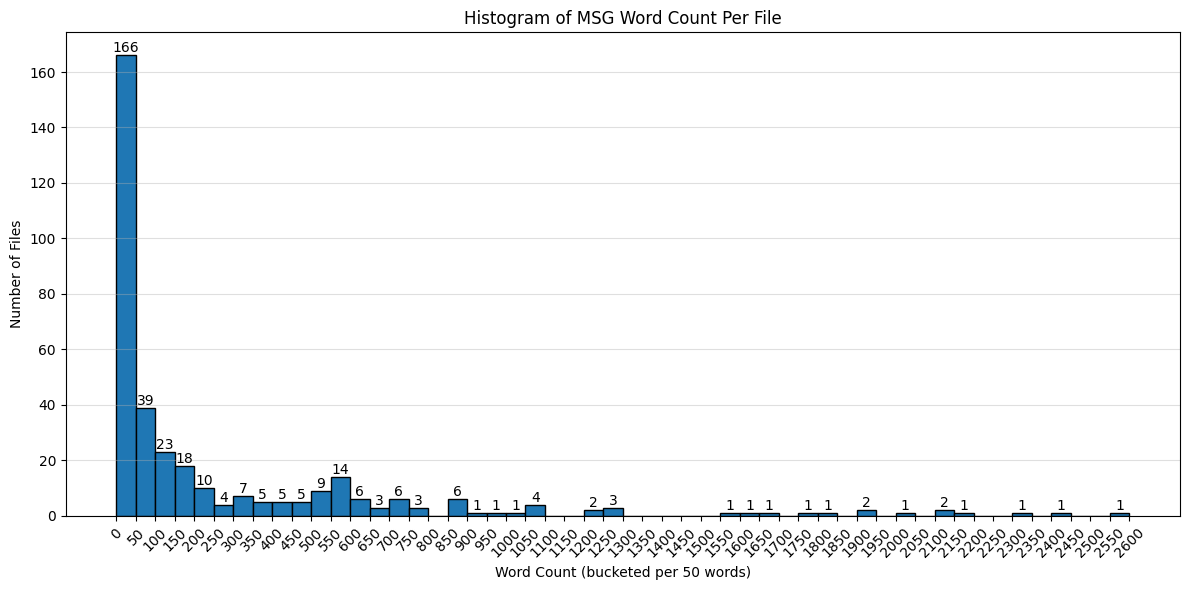

In [14]:
plt.figure(figsize=(12, 6))

counts, bins, patches = plt.hist(
    all_word_counts,
    bins=range(0, max(all_word_counts) + BUCKET_SIZE, BUCKET_SIZE),
    edgecolor='black'
)

plt.title("Histogram of MSG Word Count Per File")
plt.xlabel("Word Count (bucketed per 50 words)")
plt.ylabel("Number of Files")

plt.xticks(bins, rotation=45)

plt.grid(axis='y', alpha=0.4)

# ---- ADD VALUE LABELS ON TOP OF BARS ----
for count, patch in zip(counts, patches):
    if count > 0:  # skip empty bars
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        plt.text(x, y, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
max_msg_count = 0

json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

for filename in tqdm(json_files, desc="Checking MSG counts"):
    path = os.path.join(folder_path, filename)

    with open(path, "r") as f:
        data = json.load(f)

    # EB extraction
    try:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["HL"]["EB"]
    except:
        eb_list = data["ISA"]["GS"]["ST"]["HL"]["HL"]["HL"]["EB"]

    for eb in eb_list:

        if not isinstance(eb, dict):
            continue

        if "MSG" not in eb:
            continue

        msg_field = eb["MSG"]
        msg_count = 0

        # -----------------------
        # CASE 1: MSG = list
        # -----------------------
        if isinstance(msg_field, list):
            for item in msg_field:

                # {"@MSG01": "text"}
                if isinstance(item, dict) and "@MSG01" in item:
                    msg_count += 1

                # "some text"
                elif isinstance(item, str):
                    msg_count += 1

        # -----------------------
        # CASE 2: MSG = dict
        # -----------------------
        elif isinstance(msg_field, dict):
            if "@MSG01" in msg_field:

                val = msg_field["@MSG01"]

                if isinstance(val, list):
                    msg_count += len(val)
                else:
                    msg_count += 1

        # -----------------------
        # CASE 3: MSG = string
        # -----------------------
        elif isinstance(msg_field, str):
            msg_count += 1

        # Update max
        if msg_count > max_msg_count:
            max_msg_count = msg_count

print("\nMaximum number of MSG subfields inside any EB:", max_msg_count)


Checking MSG counts: 100%|██████████| 400/400 [00:00<00:00, 7214.30it/s]


Maximum number of MSG subfields inside any EB: 10
